In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
#For a new user that needs to install
#!pip install wrapt --upgrade --ignore-installed
#!pip install tensorflow-gpu
#!pip install keras

In [3]:
import csv
import time
import sys
import os 

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [4]:
#put your path in possible_paths 
possible_paths = ["..\\utils\\", "../../utils/"]
for path in possible_paths:
    if os.path.isdir(path):
        utils_path = path
        
sys.path.insert(0, utils_path)   
sys.path.insert(0, utils_path)  

import utils as ut
import fancyplots as fp
from regr_models import neuralNewtorkRegression

In [5]:
#When a library is updated, run
import importlib
importlib.reload(ut)

<module 'utils' from '/home/simone/repos/IPAM2021_ML/algo/NN_tf/../../utils/utils.py'>

## Input options

In [6]:
# training options
epochs           = 100
validation_split = 0.2
batch_size       = 128
verbose_training = False
hlayers_sizes    = (100,);
learning_rate    = 0.001
scaler_type      = 'minmax' # standard, minmax, mixed
hidden_activation= 'relu'
out_activation   = 'linear' # sigmoid, linear, linear_cut, linear_cut_T3, linear_cut_lb, linear_cut_mod
loss_function    = 'mse'

show_multiepochs_pMc  = True
show_multiepochs_muMc = False
show_multiepochs_p3s  = False
epochs_list           = [10, 30, 50, 100, 150, 200, 250, 300] # used in multiepochs

use_uniform_q = True

save_plots = False # used only for multiepochs plots (not for the histograms)
#plots_dir  = '/home/simone/repos/IPAM2021_ML/notes/Figs/'
plots_dir = ''

# data paths
regr_data_dirs = ["../../datasets/GSTLAL_EarlyWarning_Dataset/Dataset/m1m2Mc/",
                  "..\\GSTLAL_EarlyWarning_Dataset\\Dataset\\m1m2Mc\\"]
for path in regr_data_dirs:
    if os.path.isdir(path):
        if use_uniform_q:
            regr_data_dir = path.replace('m1m2Mc', 'm1m2Mc_uniform_q')
        else:
            regr_data_dir = path  
        print(regr_data_dir)

../../datasets/GSTLAL_EarlyWarning_Dataset/Dataset/m1m2Mc_uniform_q/


## Load dataset

Histogram: injected


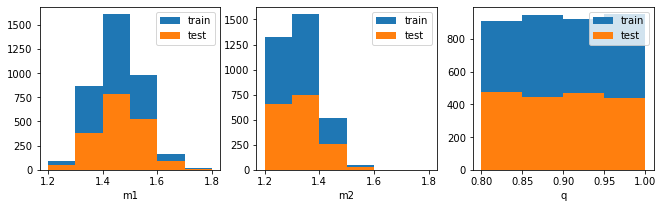

Histogram: recovered


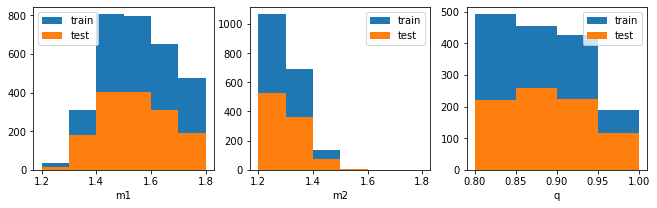

In [7]:
# load data
features_names       = ['m1', 'm2', 'Mc']
data_paths           = {}
data_paths['xtrain'] = regr_data_dir+'xtrain.csv'
data_paths['ytrain'] = regr_data_dir+'ytrain.csv'
data_paths['xtest']  = regr_data_dir+'xtest.csv'
data_paths['ytest']  = regr_data_dir+'ytest.csv'

rdl_out = ut.regressionDatasetLoader(data_paths, features_names,
                       remove_some_mass=False,
                       scaler_type=None)
xtrain_notnormalized = rdl_out['xtrain']
ytrain_notnormalized = rdl_out['ytrain']
xtest_notnormalized  = rdl_out['xtest']
ytest_notnormalized  = rdl_out['ytest']
labels               = rdl_out['labels']

# inj-histogram
print('Histogram: injected')
inj_train = ytrain_notnormalized
inj_test  = ytest_notnormalized
fig, axs = plt.subplots(1,3, figsize=(11, 3))
axs[0].hist(inj_train[:,0],bins=np.arange(1.2,1.9,0.1), alpha=1, label='train')
axs[0].hist(inj_test[:,0],bins=np.arange(1.2,1.9,0.1), alpha=1, label='test')
axs[0].set_xlabel('m1')
axs[0].legend()
axs[1].hist(inj_train[:,1],bins=np.arange(1.2,1.9,0.1), alpha=1, label='train')
axs[1].hist(inj_test[:,1],bins=np.arange(1.2,1.9,0.1), alpha=1, label='test')
axs[1].set_xlabel('m2')
axs[1].legend()
qtrain = inj_train[:,1]/inj_train[:,0]
qtest  = inj_test[:,1]/inj_test[:,0]
axs[2].hist(qtrain,bins=np.arange(0.8,1.01,0.05), alpha=1, label='train')
axs[2].hist(qtest, bins=np.arange(0.8,1.01,0.05), alpha=1, label='test')
axs[2].set_xlabel('q')
axs[2].legend()
plt.show()

# rec-histogram
print('Histogram: recovered')
rec_train = xtrain_notnormalized
rec_test  = xtest_notnormalized
fig, axs = plt.subplots(1,3, figsize=(11, 3))
axs[0].hist(rec_train[:,0],bins=np.arange(1.2,1.9,0.1), alpha=1, label='train')
axs[0].hist(rec_test[:,0],bins=np.arange(1.2,1.9,0.1), alpha=1, label='test')
axs[0].set_xlabel('m1')
axs[0].legend()
axs[1].hist(rec_train[:,1],bins=np.arange(1.2,1.9,0.1), alpha=1, label='train')
axs[1].hist(rec_test[:,1],bins=np.arange(1.2,1.9,0.1), alpha=1, label='test')
axs[1].set_xlabel('m2')
axs[1].legend()
qtrain = rec_train[:,1]/rec_train[:,0]
qtest  = rec_test[:,1]/rec_test[:,0]
axs[2].hist(qtrain,bins=np.arange(0.8,1.01,0.05), alpha=1, label='train')
axs[2].hist(qtest, bins=np.arange(0.8,1.01,0.05), alpha=1, label='test')
axs[2].set_xlabel('q')
axs[2].legend()
plt.show()


## Regression (m1,m2)

In [8]:
# train model
epochs_m1m2 = 50

xtrain_notnorm_m1m2 = xtrain_notnormalized[:,0:2]
ytrain_notnorm_m1m2 = ytrain_notnormalized[:,0:2]
xtest_notnorm_m1m2  = xtest_notnormalized[:,0:2]
ytest_notnorm_m1m2  = ytest_notnormalized[:,0:2]
labels_m1m2         = labels[0:2]

t0 = time.perf_counter()
outNN = neuralNewtorkRegression(xtrain_notnorm_m1m2, ytrain_notnorm_m1m2,
            scaler_type       = scaler_type,                   
            epochs            = epochs_m1m2, 
            batch_size        = batch_size, 
            learning_rate     = learning_rate,          
            validation_split  = validation_split,   
            verbose           = verbose_training,             
            hlayers_sizes     = hlayers_sizes,          
            out_activation    = out_activation,        
            hidden_activation = hidden_activation,
            loss_function     = 'mse')
train_time = time.perf_counter()-t0

model    = outNN["model"]
history  = outNN["history"]
Npars    = outNN["Npars"]
scaler_x = outNN["scaler_x"]
scaler_y = outNN["scaler_y"]

xtest = scaler_x.transform(xtest_notnorm_m1m2)
ytest = scaler_y.transform(ytest_notnorm_m1m2)

# predict
ypredicted = model.predict(xtest)

# print some information
metrics_dict = ut.evalutationMetricsDict(xtest,ytest,model)

# show plots and print info
asterisks = '*'*80
print(asterisks)
print('Layers: ', end='')
for layer in hlayers_sizes:
    print(layer,end=' ')
print('\ntrainable pramaters: ', Npars, \
      '\ntrain time: {:.3f}'.format(train_time), '\n', \
      asterisks, sep='', end='\n')
ut.printMetrics(metrics_dict)

# save info/score/model in the dictionary
struct_m1m2                     = lambda:0
struct_m1m2.Npars               = Npars
struct_m1m2.metrics             = metrics_dict
struct_m1m2.train_time          = train_time
struct_m1m2.Nlayers             = len(hlayers_sizes)
struct_m1m2.hlayers_sizes       = hlayers_sizes
struct_m1m2.epochs              = epochs
struct_m1m2.batch_size          = batch_size
struct_m1m2.scaler_type         = scaler_type
struct_m1m2.out_activation      = out_activation
struct_m1m2.hidden_activation   = hidden_activation
struct_m1m2.learning_rate       = learning_rate
struct_m1m2.prediction          = ypredicted
struct_m1m2.prediction_rescaled = scaler_y.inverse_transform(ypredicted)
struct_m1m2.loss_function       = loss_function
struct_m1m2.scaler_x            = scaler_x
struct_m1m2.scaler_y            = scaler_y
struct_m1m2.model               = model
struct_m1m2.history             = history

# plots
#fp.regrPredictionPlots(ytest, ypredicted, labels_m1m2, scaler=scaler_y)
#fp.plotHistory(history)
#fp.checkRegressionPlot(xtest, ytest, ypredicted, labels_m1m2, \
#                   scaler_y=scaler_y, scaler_x=scaler_x)
#fp.plotInjRecPred(ytest_notnorm_m1m2, xtest_notnorm_m1m2, \
#                  struct_m1m2.prediction_rescaled, idx_Mc=None)

# mean errors 
m1_inj  = ytest_notnormalized[:,0]
m2_inj  = ytest_notnormalized[:,1]
Mc_inj  = ut.chirpMass(m1_inj, m2_inj)
m1_pred = struct_m1m2.prediction_rescaled[:,0]
m2_pred = struct_m1m2.prediction_rescaled[:,1]
Mc_pred = ut.chirpMass(m1_pred, m2_pred)
q_inj   = m2_inj /m1_inj
q_pred  = m2_pred/m1_pred

prediction_m1m2 = np.column_stack((m1_pred, m2_pred, Mc_pred))
struct_m1m2.prediction = prediction_m1m2

error_m1 = (m1_inj-m1_pred)/m1_inj
error_m2 = (m2_inj-m2_pred)/m2_inj
error_Mc = (Mc_inj-Mc_pred)/Mc_inj
error_q  = (q_inj - q_pred)/q_inj
m1_mean_error = np.mean(np.abs(error_m1))
m2_mean_error = np.mean(np.abs(error_m2))
Mc_mean_error = np.mean(np.abs(error_Mc))
q_mean_error  = np.mean(np.abs(error_q))
print('---------------------------------')
print('m1 mean error:', m1_mean_error)
print('m2 mean error:', m2_mean_error)
print('Mc mean error:', Mc_mean_error)
print('q  mean error:', q_mean_error)

struct_m1m2.error_m1 = error_m1
struct_m1m2.error_m2 = error_m2
struct_m1m2.error_Mc = error_Mc
struct_m1m2.error_q  = error_q
struct_m1m2.me_m1 = m1_mean_error
struct_m1m2.me_m2 = m2_mean_error
struct_m1m2.me_Mc = Mc_mean_error
struct_m1m2.me_q  =  q_mean_error

********************************************************************************
Layers: 100 
trainable pramaters: 502
train time: 4.505
********************************************************************************

Final loss     : 0.04285
Final R2 mean  : 0.72968
R2[ 0]         : 0.70656
R2[ 1]         : 0.75280
---------------------------------
m1 mean error: 0.027085893479626436
m2 mean error: 0.026697356408560517
Mc mean error: 0.0010487637635625364
q  mean error: 0.05399235014898438


## Test with dirrent numbers of epochs 

In [9]:
# some functions
def PlotMultiEpochs(m1_rec_test, m2_rec_test, m1_inj_test, m2_inj_test, \
                   struct_m1m2, edict, use_train_prediction=False, save_plots=False,
                   name='new'):
    keys = list(edict.keys())
    
    # m2 plot
    plt.figure
    plt.scatter(m1_rec_test, m2_rec_test, color=[0.5,0.5,0.5], label='rec')
    plt.scatter(m1_inj_test, m2_inj_test, color=[0,0,0], label='inj')
    plt.scatter(struct_m1m2.prediction_rescaled[:,0], struct_m1m2.prediction_rescaled[:,1], \
                color=[0,1,0], marker='x', label='m1m2')
    plt.xlabel('m1',fontsize=20)
    plt.ylabel('m2', fontsize=20)
    plt.legend()
    if save_plots:
        figname = 'grey_m1m2.png'
        plt.savefig(plots_dir+figname,dpi=200,bbox_inches='tight')
    plt.show()
    
    plt.figure
    plt.scatter(m1_rec_test, m2_rec_test, color=[0.5,0.5,0.5], label='rec')
    plt.scatter(m1_inj_test, m2_inj_test, color=[0,0,0], label='inj')
    k = 0;
    colors = plt.cm.rainbow(np.linspace(0, 1, len(keys)))
    for key in keys:
        if use_train_prediction:
            m1 = edict[key].prediction_train[:,0]
            m2 = edict[key].prediction_train[:,1]
        else:
            m1 = edict[key].prediction[:,0]
            m2 = edict[key].prediction[:,1]
        plt.scatter(m1, m2, label="e: "+key, color=colors[k])
        k+=1
    plt.xlabel('m1',fontsize=20)
    plt.ylabel('m2', fontsize=20)
    plt.legend()
    if save_plots:
        figname = name+'_rainbow_m1m2.png'
        plt.savefig(plots_dir+figname,dpi=200,bbox_inches='tight')
    plt.show()
    
    # Mc plot
    plt.figure
    plt.scatter(m1_rec_test, ut.chirpMass(m1_rec_test,m2_rec_test), color=[0.5,0.5,0.5], label='rec')
    plt.scatter(m1_inj_test, ut.chirpMass(m1_inj_test,m2_inj_test), color=[0,0,0], label='inj')
    Mc0 = ut.chirpMass(struct_m1m2.prediction_rescaled[:,0],struct_m1m2.prediction_rescaled[:,1])
    plt.scatter(struct_m1m2.prediction_rescaled[:,0], Mc0, color=[0,1,0], marker='x', label='m1m2')
    plt.xlabel('m1',fontsize=20)
    plt.ylabel('Mc', fontsize=20)
    plt.legend()
    if save_plots:
        figname = 'grey_m1Mc.png'
        plt.savefig(plots_dir+figname,dpi=200,bbox_inches='tight')
    plt.show()
    
    plt.figure
    plt.scatter(m1_rec_test, ut.chirpMass(m1_rec_test,m2_rec_test), color=[0.5,0.5,0.5], label='rec')
    plt.scatter(m1_inj_test, ut.chirpMass(m1_inj_test,m2_inj_test), color=[0,0,0], label='inj')
    k = 0;
    colors = plt.cm.rainbow(np.linspace(0, 1, len(keys)))
    for key in keys:
        if use_train_prediction:
            m1 = edict[key].prediction_train[:,0]
            Mc = ut.chirpMass(edict[key].prediction_train[:,0],edict[key].prediction_train[:,1])
        else:
            m1 = edict[key].prediction[:,0]
            Mc = ut.chirpMass(edict[key].prediction[:,0],edict[key].prediction[:,1])
        plt.scatter(m1, Mc, label="e: "+key, color=colors[k])
        k+=1
    plt.xlabel('m1',fontsize=20)
    plt.ylabel('Mc', fontsize=20)
    plt.legend()
    if save_plots:
        figname = name+'_rainbow_m1Mc.png'
        plt.savefig(plots_dir+figname,dpi=200,bbox_inches='tight')
    plt.show()
    
    # q-plot
    plt.figure
    plt.scatter(m1_rec_test, m2_rec_test/m1_rec_test, color=[0.5,0.5,0.5], label='rec')
    plt.scatter(m1_inj_test, m2_inj_test/m1_inj_test, color=[0,0,0], label='inj')
    q0 = struct_m1m2.prediction_rescaled[:,1]/struct_m1m2.prediction_rescaled[:,0]
    plt.scatter(struct_m1m2.prediction_rescaled[:,0], q0, color=[0,1,0], marker='x', label='m1m2')
    plt.xlabel('m1',fontsize=20)
    plt.ylabel('q', fontsize=20)
    plt.legend()
    if save_plots:
        figname = 'grey_m1q.png'
        plt.savefig(plots_dir+figname,dpi=200,bbox_inches='tight')
    plt.show()
    
    plt.figure
    plt.scatter(m1_rec_test, m2_rec_test/m1_rec_test, color=[0.5,0.5,0.5], label='rec')
    plt.scatter(m1_inj_test, m2_inj_test/m1_inj_test, color=[0,0,0], label='inj')
    k = 0;
    colors = plt.cm.rainbow(np.linspace(0, 1, len(keys)))
    for key in keys:
        if use_train_prediction:
            m1 = edict[key].prediction_train[:,0]
            q  = edict[key].prediction_train[:,1]/edict[key].prediction_train[:,0]
        else:
            m1 = edict[key].prediction[:,0]
            q  = edict[key].prediction[:,1]/edict[key].prediction[:,0]
        plt.scatter(m1, q, label="e: "+key, color=colors[k])
        k+=1
    plt.xlabel('m1',fontsize=20)
    plt.ylabel('q', fontsize=20)
    plt.legend()
    if save_plots:
        figname = name+'_rainbow_m1q.png'
        plt.savefig(plots_dir+figname,dpi=200,bbox_inches='tight')
    plt.show()
    
def PlotMultiEpochs_errors(epochs_list, edict, struct_m1m2, epochs_m1m2, injected, recovered, name='new', save_plots=False):
    
    m1_inj  = injected[:,0]
    m2_inj  = injected[:,1]
    Mc_inj  = injected[:,2]
    q_inj   = m2_inj /m1_inj

    m1_rec  = recovered[:,0]
    m2_rec  = recovered[:,1]
    Mc_rec  = recovered[:,2]
    q_rec   = m2_rec /m1_rec

    error_m1_rec = np.mean(np.abs(m1_inj-m1_rec)/m1_inj)
    error_m2_rec = np.mean(np.abs(m2_inj-m2_rec)/m2_inj)
    error_Mc_rec = np.mean(np.abs(Mc_inj-Mc_rec)/Mc_inj)
    error_q_rec  = np.mean(np.abs(q_inj -q_rec )/q_inj )
    
    m1m2_name = 'm1m2 (e:'+str(epochs_m1m2)+')'
    
    keys = list(edict.keys())
    errors_m1_vec = []
    errors_m2_vec = []
    errors_Mc_vec = []
    errors_q_vec  = []
    for key in keys:
        errors_m1_vec.append(edict[key].me_m1)
        errors_m2_vec.append(edict[key].me_m2)
        errors_Mc_vec.append(edict[key].me_Mc)
        errors_q_vec.append(edict[key].me_q)
    
    plt.figure
    plt.hlines(error_m1_rec, 0, max(epochs_list), color=[0.5,0.5,0.5], linestyle='-.', label='m1 rec')
    plt.hlines(error_m2_rec, 0, max(epochs_list), color=[0.5,0.5,0.5], linestyle='-.', label='m2 rec')
    plt.plot(epochs_list, errors_m1_vec, marker='o', color=[0,0,1], label='m1:'+name)
    plt.hlines(struct_m1m2.me_m1, 0, max(epochs_list), color=[0,0,1], linestyle='-', label='m1: '+m1m2_name)
    plt.plot(epochs_list, errors_m2_vec, marker='o', color=[1,0.5,0], label='m2: '+name)
    plt.hlines(struct_m1m2.me_m2, 0, max(epochs_list), color=[1,0.5,0], linestyle='--', label='m2: '+m1m2_name)
    plt.xlabel('epochs', fontsize=15)
    plt.ylabel('m1-m2 errors', fontsize=15)
    plt.legend()
    if save_plots:
        figname = name+'_err_m1m2.png'
        plt.savefig(plots_dir+figname,dpi=200,bbox_inches='tight')
    plt.show()
    
    plt.figure
    plt.hlines(error_Mc_rec, 0, max(epochs_list), color=[0.5,0.5,0.5], linestyle='-.', label='Mc rec')
    plt.plot(epochs_list, errors_Mc_vec, marker='o', color=[0,1,0], label=name)
    plt.hlines(struct_m1m2.me_Mc, 0, max(epochs_list), color=[0,1,0], linestyle='--', label=m1m2_name)
    plt.xlabel('epochs', fontsize=15)
    plt.ylabel('Mc errors', fontsize=15)
    plt.legend()
    if save_plots:
        figname = name+'_err_Mc.png'
        plt.savefig(plots_dir+figname,dpi=200,bbox_inches='tight')
    plt.show()
    
    plt.figure
    plt.hlines(error_q_rec, 0, max(epochs_list), color=[0.5,0.5,0.5], linestyle='-.', label='q rec')
    plt.plot(epochs_list, errors_q_vec, marker='o', color=[1,0,0], label=name)
    plt.hlines(struct_m1m2.me_q, 0, max(epochs_list), color=[1,0,0], linestyle='--', label=m1m2_name)
    plt.xlabel('epochs', fontsize=15)
    plt.ylabel('q errors', fontsize=15)
    plt.legend()
    if save_plots:
        figname = name+'_err_q.png'
        plt.savefig(plots_dir+figname,dpi=200,bbox_inches='tight')
    plt.show()
    
def ErrorHistograms(edict, struct_m1m2, keys2plot, injected, recovered):
    all_keys = list(edict.keys())
    for key in keys2plot:
        if not key in all_keys:
            print(key, 'is not a valid key!')
            sys.exit()
    nkeys = len(keys2plot)
    all_colors = plt.cm.rainbow(np.linspace(0, 1, len(all_keys)))
    colors = []
    for key in keys2plot:
        for k in range(0, len(all_keys)):
            if key==all_keys[k]:
                colors.append(all_colors[k])

    m1_inj  = injected[:,0]
    m2_inj  = injected[:,1]
    Mc_inj  = injected[:,2]
    q_inj   = m2_inj /m1_inj
    m1_rec  = recovered[:,0]
    m2_rec  = recovered[:,1]
    Mc_rec  = recovered[:,2]
    q_rec   = m2_rec /m1_rec

    nbins = 30

    fig, axs = plt.subplots(2,2, figsize=(15, 10))
    #axs[0,0].axvline(0, color=[0,0,0], linestyle='-')
    #axs[0,1].axvline(0, color=[0,0,0], linestyle='-')
    #axs[1,0].axvline(0, color=[0,0,0], linestyle='-')
    #axs[1,1].axvline(0, color=[0,0,0], linestyle='-')
    # plot errors for recovered quantities 
    error_m1_rec = (m1_inj-m1_rec)/m1_inj
    error_m2_rec = (m2_inj-m2_rec)/m2_inj
    error_Mc_rec = (Mc_inj-Mc_rec)/Mc_inj
    error_q_rec  = (q_inj - q_rec)/q_inj
    min_m1 = min(error_m1_rec)
    max_m1 = max(error_m1_rec)
    min_m2 = min(error_m2_rec)
    max_m2 = max(error_m2_rec)
    min_Mc = min(error_Mc_rec)
    max_Mc = max(error_Mc_rec)
    if abs(min_Mc)>max_Mc: # remove the outlier!
        min_Mc = -max_Mc
    min_q  = min(error_q_rec)
    max_q  = max(error_q_rec)
    m1_step = (max_m1-min_m1)/nbins
    m2_step = (max_m2-min_m2)/nbins
    Mc_step = (max_Mc-min_Mc)/nbins
    q_step  = (max_q -min_q )/nbins
    axs[0,0].hist(error_m1_rec,bins=np.arange(min_m1, max_m1, m1_step), alpha=1, label="rec", color=[0.8,0.8,0.8])
    axs[0,1].hist(error_m2_rec,bins=np.arange(min_m2, max_m2, m2_step), alpha=1, label="rec", color=[0.8,0.8,0.8])
    axs[1,0].hist(error_Mc_rec,bins=np.arange(min_Mc,max_Mc,Mc_step), alpha=1, label="rec", color=[0.8,0.8,0.8])
    axs[1,1].hist(error_q_rec, bins=np.arange(min_q, max_q, q_step ), alpha=1, label="rec", color=[0.8,0.8,0.8])
    # plot errors for (m1,m2) regression
    prediction = struct_m1m2.prediction
    m1_pred  = prediction[:,0]
    m2_pred  = prediction[:,1]
    Mc_pred  = prediction[:,2]
    q_pred   = m2_pred/m1_pred
    error_m1 = (m1_inj-m1_pred)/m1_inj
    error_m2 = (m2_inj-m2_pred)/m2_inj
    error_Mc = (Mc_inj-Mc_pred)/Mc_inj
    error_q  = (q_inj - q_pred)/q_inj
    min_m1 = min(error_m1)
    max_m1 = max(error_m1)
    min_m2 = min(error_m2)
    max_m2 = max(error_m2)
    min_Mc = min(error_Mc)
    max_Mc = max(error_Mc)
    if abs(min_Mc)>max_Mc:
        min_Mc = -max_Mc
    min_q  = min(error_q)
    max_q  = max(error_q)
    axs[0,0].hist(error_m1,bins=np.arange(min_m1,max_m1,m1_step), alpha=0.7, label="pred", color=[0,1,0])
    axs[0,1].hist(error_m2,bins=np.arange(min_m2,max_m2,m2_step), alpha=0.7, label="pred", color=[0,1,0])
    axs[1,0].hist(error_Mc,bins=np.arange(min_Mc,max_Mc,Mc_step), alpha=0.7, label="pred", color=[0,1,0])
    axs[1,1].hist(error_q, bins=np.arange(min_q, max_q, q_step ), alpha=0.7, label="pred", color=[0,1,0])
    axs[0,0].axvline(np.mean(error_m1), color=[0,1,0], linestyle='--')
    axs[0,1].axvline(np.mean(error_m2), color=[0,1,0], linestyle='--')
    axs[1,0].axvline(np.mean(error_Mc), color=[0,1,0], linestyle='--')
    axs[1,1].axvline(np.mean(error_q ), color=[0,1,0], linestyle='--')
    k = 0
    for key in keys2plot:
        mydict = edict[key]
        prediction = mydict.prediction
        m1_pred = prediction[:,0]
        m2_pred = prediction[:,1]
        Mc_pred  = prediction[:,2]
        q_pred   = m2_pred/m1_pred
        error_m1 = (m1_inj-m1_pred)/m1_inj
        error_m2 = (m2_inj-m2_pred)/m2_inj
        error_Mc = (Mc_inj-Mc_pred)/Mc_inj
        error_q  = (q_inj - q_pred)/q_inj
        min_m1 = min(error_m1)
        max_m1 = max(error_m1)
        min_m2 = min(error_m2)
        max_m2 = max(error_m2)
        min_Mc = min(error_Mc)
        max_Mc = max(error_Mc)
        if abs(min_Mc)>max_Mc:
            min_Mc = -max_Mc
        min_q  = min(error_q)
        max_q  = max(error_q)
        axs[0,0].hist(error_m1,bins=np.arange(min_m1,max_m1,m1_step), alpha=0.9-0.1*k, label="e: "+key, color=colors[k])
        axs[0,1].hist(error_m2,bins=np.arange(min_m2,max_m2,m2_step), alpha=0.9-0.1*k, label="e: "+key, color=colors[k])
        axs[1,0].hist(error_Mc,bins=np.arange(min_Mc,max_Mc,Mc_step), alpha=0.9-0.1*k,label="e: "+key, color=colors[k])
        axs[1,1].hist(error_q, bins=np.arange(min_q, max_q, q_step ), alpha=0.9-0.1*k, label="e: "+key, color=colors[k])
        color    = colors[k]
        color[3] =  0.9-0.1*k
        axs[0,0].axvline(np.mean(error_m1), color=color, linestyle='--')
        axs[0,1].axvline(np.mean(error_m2), color=color, linestyle='--')
        axs[1,0].axvline(np.mean(error_Mc), color=color, linestyle='--')
        axs[1,1].axvline(np.mean(error_q ), color=color, linestyle='--')
        #axs[0,0].axvline(np.median(error_m1), color=color, linestyle=':')
        #axs[0,1].axvline(np.median(error_m2), color=color, linestyle=':')
        #axs[1,0].axvline(np.median(error_Mc), color=color, linestyle=':')
        #axs[1,1].axvline(np.median(error_q ), color=color, linestyle=':')
        k += 1
    axs[0,0].set_title('m1', fontsize=22)
    axs[0,0].legend(fontsize=20)
    axs[0,1].set_title('m2', fontsize=22)
    axs[0,1].legend(fontsize=20)
    axs[1,0].set_title('Mc', fontsize=22)
    axs[1,0].legend(fontsize=20)
    axs[1,0].set_yscale('log', nonposy='clip')
    axs[1,1].set_title('q', fontsize=22)
    axs[1,1].legend(fontsize=20)
    
    axs[0,0].axvline(np.mean(error_m1_rec), color=[0.8,0.8,0.8], linestyle='--')
    axs[0,1].axvline(np.mean(error_m2_rec), color=[0.8,0.8,0.8], linestyle='--')
    axs[1,0].axvline(np.mean(error_Mc_rec), color=[0.8,0.8,0.8], linestyle='--')
    axs[1,1].axvline(np.mean(error_q_rec ), color=[0.8,0.8,0.8], linestyle='--')
    #axs[0,0].axvline(np.median(error_m1_rec), color=[0.8,0.8,0.8], linestyle=':')
    #axs[0,1].axvline(np.median(error_m2_rec), color=[0.8,0.8,0.8], linestyle=':')
    #axs[1,0].axvline(np.median(error_Mc_rec), color=[0.8,0.8,0.8], linestyle=':')
    #axs[1,1].axvline(np.median(error_q_rec ), color=[0.8,0.8,0.8], linestyle=':')
    
    plt.show()
    
def ErrorHistograms_m1m2(struct_m1m2, injected, recovered):
    m1_inj  = injected[:,0]
    m2_inj  = injected[:,1]
    Mc_inj  = injected[:,2]
    q_inj   = m2_inj /m1_inj

    m1_rec  = recovered[:,0]
    m2_rec  = recovered[:,1]
    Mc_rec  = recovered[:,2]
    q_rec   = m2_rec /m1_rec

    nbins = 30

    fig, axs = plt.subplots(2,2, figsize=(15, 10))
    #axs[0,0].axvline(0, color=[0,0,0], linestyle='-')
    #axs[0,1].axvline(0, color=[0,0,0], linestyle='-')
    #axs[1,0].axvline(0, color=[0,0,0], linestyle='-')
    #axs[1,1].axvline(0, color=[0,0,0], linestyle='-')
    error_m1_rec = (m1_inj-m1_rec)/m1_inj
    error_m2_rec = (m2_inj-m2_rec)/m2_inj
    min_m1 = min(error_m1_rec)
    max_m1 = max(error_m1_rec)
    min_m2 = min(error_m2_rec)
    max_m2 = max(error_m2_rec)
    error_Mc_rec = (Mc_inj-Mc_rec)/Mc_inj
    error_q_rec  = (q_inj - q_rec)/q_inj
    min_Mc = min(error_Mc_rec)
    max_Mc = max(error_Mc_rec)
    if abs(min_Mc)>max_Mc: # remove the outlier!
        min_Mc = -max_Mc
    min_q  = min(error_q_rec)
    max_q  = max(error_q_rec)
    m1_step = (max_m1-min_m1)/nbins
    m2_step = (max_m2-min_m2)/nbins
    Mc_step = (max_Mc-min_Mc)/nbins
    q_step  = (max_q -min_q )/nbins
    axs[0,0].hist(error_m1_rec,bins=np.arange(min_m1, max_m1, m1_step), alpha=1, label="rec", color=[0.8,0.8,0.8])
    axs[0,1].hist(error_m2_rec,bins=np.arange(min_m2, max_m2, m2_step), alpha=1, label="rec", color=[0.8,0.8,0.8])
    axs[1,0].hist(error_Mc_rec,bins=np.arange(min_Mc,max_Mc,Mc_step), alpha=1, label="rec", color=[0.8,0.8,0.8])
    axs[1,1].hist(error_q_rec, bins=np.arange(min_q, max_q, q_step ), alpha=1, label="rec", color=[0.8,0.8,0.8])
    
    prediction = struct_m1m2.prediction
    m1_pred  = prediction[:,0]
    m2_pred  = prediction[:,1]
    Mc_pred  = prediction[:,2]
    q_pred   = m2_pred/m1_pred
    error_m1 = (m1_inj-m1_pred)/m1_inj
    error_m2 = (m2_inj-m2_pred)/m2_inj
    error_Mc = (Mc_inj-Mc_pred)/Mc_inj
    error_q  = (q_inj - q_pred)/q_inj
    min_m1 = min(error_m1)
    max_m1 = max(error_m1)
    min_m2 = min(error_m2)
    max_m2 = max(error_m2)
    min_Mc = min(error_Mc)
    max_Mc = max(error_Mc)
    if abs(min_Mc)>max_Mc:
        min_Mc = -max_Mc
    min_q  = min(error_q)
    max_q  = max(error_q)
    axs[0,0].hist(error_m1,bins=np.arange(min_m1,max_m1,m1_step), alpha=0.7, label="pred", color=[0,1,0])
    axs[0,1].hist(error_m2,bins=np.arange(min_m2,max_m2,m2_step), alpha=0.7, label="pred", color=[0,1,0])
    axs[0,0].set_title('m1', fontsize=22)
    axs[0,0].legend(fontsize=20)
    axs[0,1].set_title('m2', fontsize=22)
    axs[0,1].legend(fontsize=20)
    axs[1,0].hist(error_Mc,bins=np.arange(min_Mc,max_Mc,Mc_step), alpha=0.7, label="pred", color=[0,1,0])
    axs[1,1].hist(error_q, bins=np.arange(min_q, max_q, q_step ), alpha=0.7, label="pred", color=[0,1,0])
    axs[1,0].set_title('Mc', fontsize=22)
    axs[1,0].legend(fontsize=20)
    axs[1,0].set_yscale('log', nonposy='clip')
    axs[1,1].set_title('q', fontsize=22)
    axs[1,1].legend(fontsize=20)
    
    axs[0,0].axvline(np.mean(error_m1_rec), color=[0.8,0.8,0.8], linestyle='--')
    axs[0,1].axvline(np.mean(error_m2_rec), color=[0.8,0.8,0.8], linestyle='--')
    axs[1,0].axvline(np.mean(error_Mc_rec), color=[0.8,0.8,0.8], linestyle='--')
    axs[1,1].axvline(np.mean(error_q_rec ), color=[0.8,0.8,0.8], linestyle='--')
    #axs[0,0].axvline(np.median(error_m1_rec), color=[0.8,0.8,0.8], linestyle=':')
    #axs[0,1].axvline(np.median(error_m2_rec), color=[0.8,0.8,0.8], linestyle=':')
    #axs[1,0].axvline(np.median(error_Mc_rec), color=[0.8,0.8,0.8], linestyle=':')
    #axs[1,1].axvline(np.median(error_q_rec ), color=[0.8,0.8,0.8], linestyle=':')
    
    axs[0,0].axvline(np.mean(error_m1), color=[0,1,0], linestyle='--')
    axs[0,1].axvline(np.mean(error_m2), color=[0,1,0], linestyle='--')
    axs[1,0].axvline(np.mean(error_Mc), color=[0,1,0], linestyle='--')
    axs[1,1].axvline(np.mean(error_q ), color=[0,1,0], linestyle='--')
    #axs[0,0].axvline(np.median(error_m1), color=[0,1,0], linestyle=':')
    #axs[0,1].axvline(np.median(error_m2), color=[0,1,0], linestyle=':')
    #axs[1,0].axvline(np.median(error_Mc), color=[0,1,0], linestyle=':')
    #axs[1,1].axvline(np.median(error_q ), color=[0,1,0], linestyle=':')
    
    plt.show()

In [10]:
if show_multiepochs_pMc:
    
    pcoeff            = 3
    loss_function_pMc = loss_function
    hlayers_sizes_pMc = hlayers_sizes
    
    xtrain_notnormalized = rdl_out['xtrain']
    ytrain_notnormalized = rdl_out['ytrain']
    xtest_notnormalized  = rdl_out['xtest']
    ytest_notnormalized  = rdl_out['ytest']
    labels               = rdl_out['labels']

    Ntrain = len(xtrain_notnormalized[:,0])
    Ntest  = len(xtest_notnormalized[:,1])
    xtrain_notnorm_pMc = np.zeros((Ntrain,2))
    ytrain_notnorm_pMc = np.zeros((Ntrain,2))
    xtest_notnorm_pMc  = np.zeros((Ntest,2))
    ytest_notnorm_pMc  = np.zeros((Ntest,2))

    m1_rec_train = xtrain_notnormalized[:,0]
    m2_rec_train = xtrain_notnormalized[:,1]
    m1_inj_train = ytrain_notnormalized[:,0]
    m2_inj_train = ytrain_notnormalized[:,1]
    m1_rec_test  = xtest_notnormalized[:,0]
    m2_rec_test  = xtest_notnormalized[:,1]
    m1_inj_test  = ytest_notnormalized[:,0]
    m2_inj_test  = ytest_notnormalized[:,1]

    xtrain_notnorm_pMc[:,0] = (m1_rec_train*m2_rec_train)**pcoeff
    xtrain_notnorm_pMc[:,1] = xtrain_notnormalized[:,2]
    ytrain_notnorm_pMc[:,0] = (m1_inj_train*m2_inj_train)**pcoeff
    ytrain_notnorm_pMc[:,1] = ytrain_notnormalized[:,2]
    xtest_notnorm_pMc[:,0]  = (m1_rec_test*m2_rec_test)**pcoeff
    xtest_notnorm_pMc[:,1]  = xtest_notnormalized[:,2]
    ytest_notnorm_pMc[:,0]  = (m1_inj_test*m2_inj_test)**pcoeff
    ytest_notnorm_pMc[:,1]  = ytest_notnormalized[:,2]

    labels_pMc = ['p'+str(pcoeff), 'Mc']
    
     # train model
    t0 = time.perf_counter()
    outNN = neuralNewtorkRegression(xtrain_notnorm_pMc, ytrain_notnorm_pMc,
                scaler_type       = scaler_type,                   
                epochs            = max(epochs_list), 
                batch_size        = batch_size, 
                learning_rate     = learning_rate,          
                validation_split  = validation_split,   
                verbose           = verbose_training,             
                hlayers_sizes     = hlayers_sizes_pMc,          
                out_activation    = out_activation,        
                hidden_activation = hidden_activation,
                loss_function     = loss_function_pMc,
                use_checkpoints   = True, 
                checkpoints_freq  = np.gcd.reduce(epochs_list))
    train_time = time.perf_counter()-t0
    
    model_pMc       = outNN["model"]
    Npars_pMc       = outNN["Npars"]
    scaler_x_pMc    = outNN["scaler_x"]
    scaler_y_pMc    = outNN["scaler_y"]
    checkpoints_dir = outNN["checkpoints_dir"]
    
    asterisks = '*'*80
    print(asterisks)
    print('Layers: ', end='')
    for layer in hlayers_sizes_pMc:
        print(layer,end=' ')
    print('\ntrainable parameters: ', Npars_pMc, '\n', asterisks, sep='', end='\n')
            
    # train for all the epochs in epochs_list and save in a dict
    estruct_pMc = {}
    for epochs_pMc in epochs_list:
        model_pMc.load_weights(checkpoints_dir+'/cp-{:06d}.ckpt'.format(epochs_pMc))
        
        xtest_pMc = scaler_x_pMc.transform(xtest_notnorm_pMc)
        ytest_pMc = scaler_y_pMc.transform(ytest_notnorm_pMc)

        # predict
        ypredicted_pMc = model_pMc.predict(xtest_pMc)

        # print some information
        metrics_struct_pMc = ut.evalutationMetricsDict(xtest_pMc,ytest_pMc,model_pMc)

        # save info/score/model in the dictionary
        struct_pMc                      = lambda:0
        struct_pMc.Npars                = Npars_pMc
        struct_pMc.metrics              = metrics_struct_pMc
        struct_pMc.train_time           = train_time
        struct_pMc.Nlayers              = len(hlayers_sizes)
        struct_pMc.hlayers_sizes        = hlayers_sizes_pMc
        struct_pMc.epochs               = epochs_pMc
        struct_pMc.batch_size           = batch_size
        struct_pMc.scaler_type          = scaler_type
        struct_pMc.out_activation       = out_activation
        struct_pMc.hidden_activation    = hidden_activation
        struct_pMc.learning_rate        = learning_rate
        struct_pMc.prediction0          = ypredicted_pMc
        struct_pMc.prediction0_rescaled = scaler_y_pMc.inverse_transform(ypredicted_pMc)
        struct_pMc.loss_function        = loss_function_pMc
        struct_pMc.scaler_x             = scaler_x_pMc
        struct_pMc.scaler_y             = scaler_y_pMc
        struct_pMc.model                = model_pMc

        p_pred  = (struct_pMc.prediction0_rescaled[:,0])**(1/pcoeff)
        Mc_pred = struct_pMc.prediction0_rescaled[:,1]
        m1_pred, _ = ut.findm1m2FrompMc_Mod(p_pred,Mc_pred)
        
        # now enforce consistency between m1,m2 and Mc
        m2_pred = ut.findSecondMassFromMc(Mc_pred, m1_pred)
        # check that m1 is always the biggest
        for i in range(0,len(m2_pred)):
            if m2_pred[i]>m1_pred[i]:
                tmp        = m2_pred[i]
                m2_pred[i] = m1_pred[i]
                m1_pred[i] = tmp
                #print(i, 'swapping')

        prediction_pMc = np.column_stack((m1_pred, m2_pred, Mc_pred))
        struct_pMc.prediction = prediction_pMc
        
        # prediction on the training dataset 
        struct_pMc.prediction0_train          = model_pMc.predict(scaler_x_pMc.transform(xtrain_notnorm_pMc))
        struct_pMc.prediction0_train_rescaled = scaler_y_pMc.inverse_transform(struct_pMc.prediction0_train)
        p_pred_train     = (struct_pMc.prediction0_train_rescaled[:,0])**(1/pcoeff)
        Mc_pred_train    = struct_pMc.prediction0_train_rescaled[:,1]
        m1_pred_train, _ = ut.findm1m2FrompMc_Mod(p_pred_train,Mc_pred_train)
        m2_pred_train    = ut.findSecondMassFromMc(Mc_pred_train, m1_pred_train)
        for i in range(0,len(m2_pred_train)):
            if m2_pred_train[i]>m1_pred_train[i]:
                tmp              = m2_pred_train[i]
                m2_pred_train[i] = m1_pred_train[i]
                m1_pred_train[i] = tmp
        prediction_pMc_train = np.column_stack((m1_pred_train, m2_pred_train, Mc_pred_train))
        struct_pMc.prediction_train = prediction_pMc_train
        
        nan_counter = 0;
        for i in range(0,len(m1_pred)):
            if np.isnan(m1_pred[i]):
                #print(p_pred[i], Mc_pred[i])
                nan_counter += 1
        if nan_counter>0:
            print(asterisks, '\nNaN found:', nan_counter)

        # mean errors 
        m1_inj  = ytest_notnormalized[:,0]
        m2_inj  = ytest_notnormalized[:,1]
        Mc_inj  = ytest_notnormalized[:,2]
        q_inj   = m2_inj /m1_inj
        q_pred  = m2_pred/m1_pred
        
        error_m1 = (m1_inj-m1_pred)/m1_inj
        error_m2 = (m2_inj-m2_pred)/m2_inj
        error_Mc = (Mc_inj-Mc_pred)/Mc_inj
        error_q  = (q_inj - q_pred)/q_inj
        m1_mean_error = np.mean(np.abs(error_m1))
        m2_mean_error = np.mean(np.abs(error_m2))
        Mc_mean_error = np.mean(np.abs(error_Mc))
        q_mean_error  = np.mean(np.abs(error_q))
        #print('-----------------------------')
        #print('m1 mean error:', m1_mean_error)
        #print('m2 mean error:', m2_mean_error)
        #print('Mc mean error:', Mc_mean_error)
        #print('q  mean error:', q_mean_error)
        struct_pMc.error_m1 = error_m1
        struct_pMc.error_m2 = error_m2
        struct_pMc.error_Mc = error_Mc
        struct_pMc.error_q  = error_q
        struct_pMc.me_m1 = m1_mean_error
        struct_pMc.me_m2 = m2_mean_error
        struct_pMc.me_Mc = Mc_mean_error
        struct_pMc.me_q  =  q_mean_error
        
        estruct_pMc[str(epochs_pMc)] = struct_pMc
        
        del struct_pMc


********************************************************************************
Layers: 100 
trainable parameters: 502
********************************************************************************


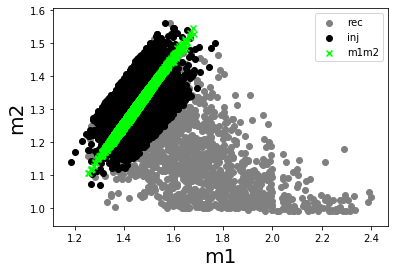

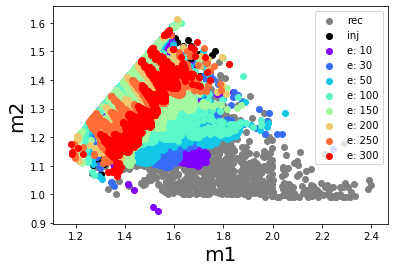

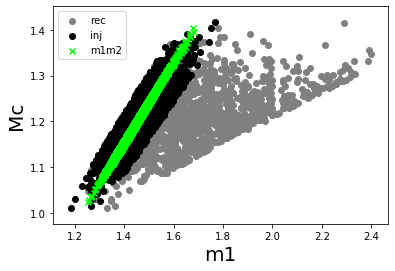

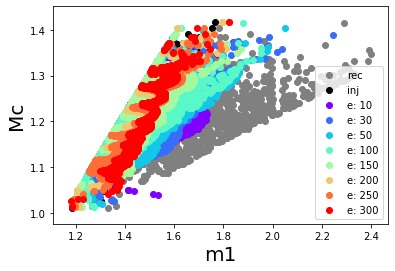

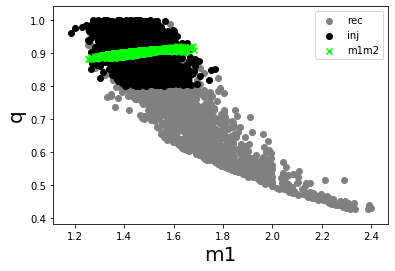

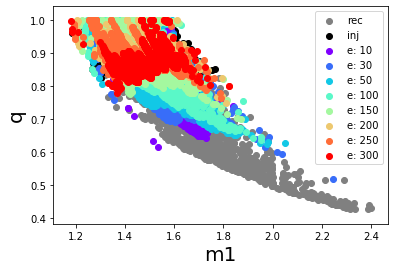

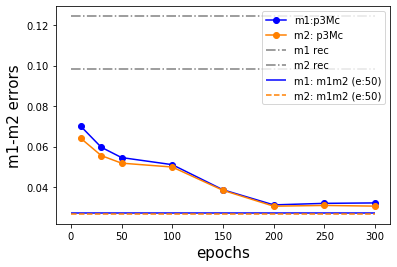

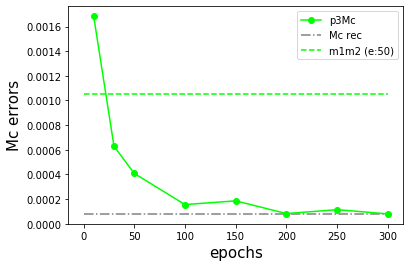

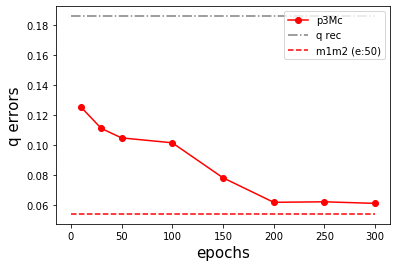

In [11]:
if show_multiepochs_pMc:   
    # use the epochs' dictionary for plotting stuff
    PlotMultiEpochs(m1_rec_test, m2_rec_test, m1_inj_test, m2_inj_test, struct_m1m2, estruct_pMc, \
                   use_train_prediction=False, save_plots=save_plots, name='p'+str(pcoeff)+'Mc')
    PlotMultiEpochs_errors(epochs_list, estruct_pMc, struct_m1m2, epochs_m1m2, ytrain_notnormalized, \
                           xtrain_notnormalized, save_plots=save_plots,\
                           name='p'+str(pcoeff)+'Mc')

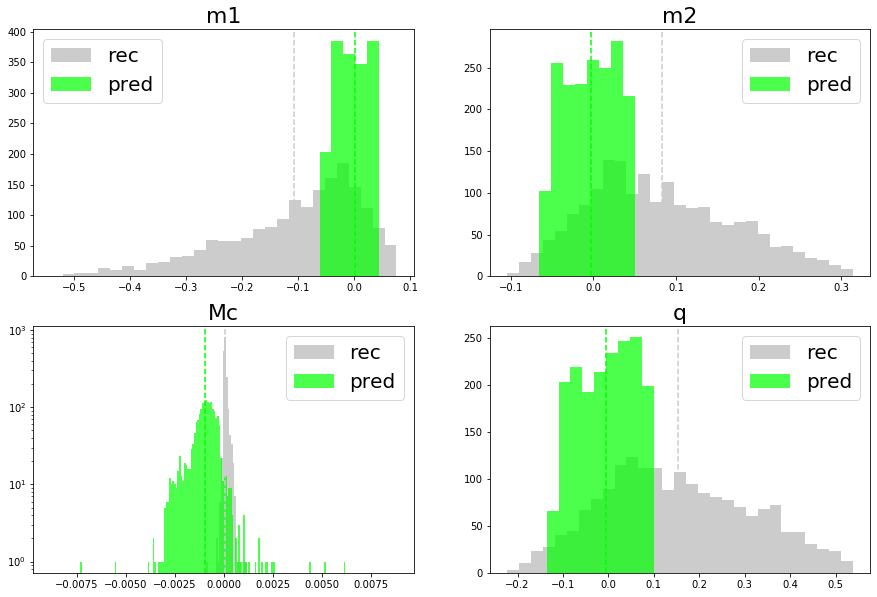

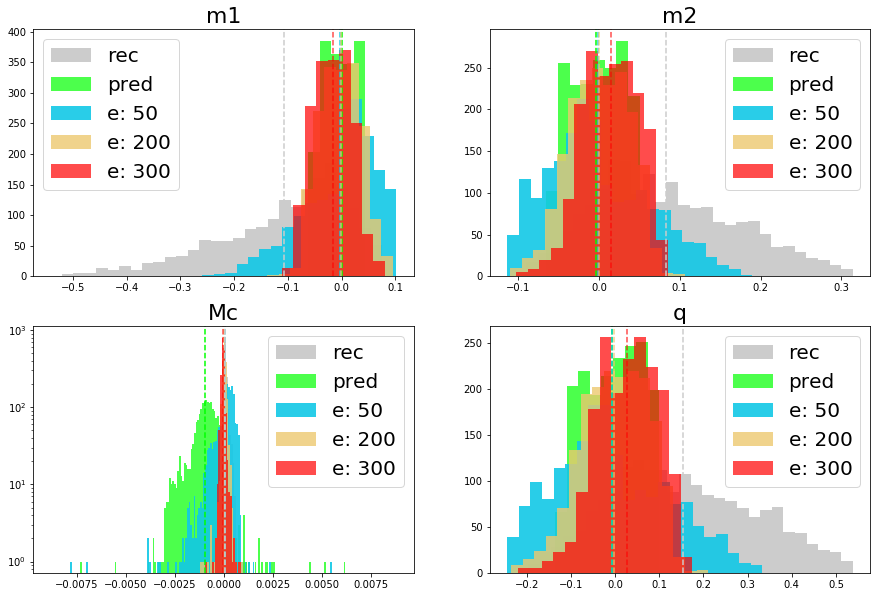

In [12]:
if show_multiepochs_pMc:
    ErrorHistograms_m1m2(struct_m1m2, ytest_notnormalized, xtest_notnormalized)
    ErrorHistograms(estruct_pMc, struct_m1m2, ["50", "200", "300"], ytest_notnormalized, xtest_notnormalized)

In [13]:
if show_multiepochs_muMc:
    loss_function_muMc = loss_function
    hlayers_sizes_muMc = hlayers_sizes
    
    xtrain_notnormalized = rdl_out['xtrain']
    ytrain_notnormalized = rdl_out['ytrain']
    xtest_notnormalized  = rdl_out['xtest']
    ytest_notnormalized  = rdl_out['ytest']
    labels               = rdl_out['labels']

    Ntrain = len(xtrain_notnormalized[:,0])
    Ntest  = len(xtest_notnormalized[:,1])
    xtrain_notnorm_muMc = np.zeros((Ntrain,2))
    ytrain_notnorm_muMc = np.zeros((Ntrain,2))
    xtest_notnorm_muMc  = np.zeros((Ntest,2))
    ytest_notnorm_muMc  = np.zeros((Ntest,2))

    m1_rec_train = xtrain_notnormalized[:,0]
    m2_rec_train = xtrain_notnormalized[:,1]
    m1_inj_train = ytrain_notnormalized[:,0]
    m2_inj_train = ytrain_notnormalized[:,1]
    m1_rec_test  = xtest_notnormalized[:,0]
    m2_rec_test  = xtest_notnormalized[:,1]
    m1_inj_test  = ytest_notnormalized[:,0]
    m2_inj_test  = ytest_notnormalized[:,1]

    xtrain_notnorm_muMc[:,0] = ut.reducedMass(m1_rec_train,m2_rec_train)
    xtrain_notnorm_muMc[:,1] = xtrain_notnormalized[:,2]
    ytrain_notnorm_muMc[:,0] = ut.reducedMass(m1_inj_train,m2_inj_train)
    ytrain_notnorm_muMc[:,1] = ytrain_notnormalized[:,2]
    xtest_notnorm_muMc[:,0]  = ut.reducedMass(m1_rec_test,m2_rec_test)
    xtest_notnorm_muMc[:,1]  = xtest_notnormalized[:,2]
    ytest_notnorm_muMc[:,0]  = ut.reducedMass(m1_inj_test,m2_inj_test)
    ytest_notnorm_muMc[:,1]  = ytest_notnormalized[:,2]

    labels_muMc = ['mu', 'Mc']
    
    # train model
    t0 = time.perf_counter()
    outNN = neuralNewtorkRegression(xtrain_notnorm_muMc, ytrain_notnorm_muMc,
                scaler_type       = scaler_type,                   
                epochs            = max(epochs_list), 
                batch_size        = batch_size, 
                learning_rate     = learning_rate,          
                validation_split  = validation_split,   
                verbose           = verbose_training,             
                hlayers_sizes     = hlayers_sizes_muMc,          
                out_activation    = out_activation,        
                hidden_activation = hidden_activation,
                loss_function     = loss_function_muMc,
                use_checkpoints   = True, 
                checkpoints_freq  = np.gcd.reduce(epochs_list))
    train_time = time.perf_counter()-t0

    model_muMc      = outNN["model"]
    history_muMc    = outNN["history"]
    Npars_muMc      = outNN["Npars"]
    scaler_x_muMc   = outNN["scaler_x"]
    scaler_y_muMc   = outNN["scaler_y"]
    checkpoints_dir = outNN["checkpoints_dir"]
    
    asterisks = '*'*80
    print(asterisks)
    print('Layers: ', end='')
    for layer in hlayers_sizes_muMc:
        print(layer,end=' ')
    print('\ntrainable parameters: ', Npars_muMc, '\n', asterisks, sep='', end='\n')
    
    # train for all the epochs in epochs_list and save in a dict
    estruct_muMc = {}
    for epochs_muMc in epochs_list:
        
        model_muMc.load_weights(checkpoints_dir+'/cp-{:06d}.ckpt'.format(epochs_muMc))
        
        xtest_muMc = scaler_x_muMc.transform(xtest_notnorm_muMc)
        ytest_muMc = scaler_y_muMc.transform(ytest_notnorm_muMc)

        # predict
        ypredicted_muMc = model_muMc.predict(xtest_muMc)

        # print some information
        metrics_struct_muMc = ut.evalutationMetricsDict(xtest_muMc,ytest_muMc,model_muMc)

        # save info/score/model in the dictionary
        struct_muMc                      = lambda:0
        struct_muMc.Npars                = Npars_muMc
        struct_muMc.metrics              = metrics_struct_muMc
        struct_muMc.train_time           = train_time
        struct_muMc.Nlayers              = len(hlayers_sizes)
        struct_muMc.hlayers_sizes        = hlayers_sizes_muMc
        struct_muMc.epochs               = epochs_muMc
        struct_muMc.batch_size           = batch_size
        struct_muMc.scaler_type          = scaler_type
        struct_muMc.out_activation       = out_activation
        struct_muMc.hidden_activation    = hidden_activation
        struct_muMc.learning_rate        = learning_rate
        struct_muMc.prediction0          = ypredicted_muMc
        struct_muMc.prediction0_rescaled = scaler_y_muMc.inverse_transform(ypredicted_muMc)
        struct_muMc.loss_function        = loss_function_muMc
        struct_muMc.scaler_x             = scaler_x_muMc
        struct_muMc.scaler_y             = scaler_y_muMc
        struct_muMc.model                = model_muMc

        mu_pred  = struct_muMc.prediction0_rescaled[:,0]
        Mc_pred  = struct_muMc.prediction0_rescaled[:,1]
        m1_pred, m2_pred = ut.findm1m2FromMcmu(Mc_pred,mu_pred)
        
        for i in range(0,len(m2_pred)):
            if m2_pred[i]>m1_pred[i]:
                tmp        = m2_pred[i]
                m2_pred[i] = m1_pred[i]
                m1_pred[i] = tmp

        prediction_muMc = np.column_stack((m1_pred, m2_pred, Mc_pred))
        struct_muMc.prediction = prediction_muMc
        
        # prediction on the training dataset 
        struct_muMc.prediction0_train          = model_muMc.predict(scaler_x_muMc.transform(xtrain_notnorm_muMc))
        struct_muMc.prediction0_train_rescaled = scaler_y_muMc.inverse_transform(struct_muMc.prediction0_train)
        mu_pred_train    = struct_muMc.prediction0_train_rescaled[:,0]
        Mc_pred_train    = struct_muMc.prediction0_train_rescaled[:,1]
        m1_pred_train, m2_pred_train = ut.findm1m2FromMcmu(Mc_pred_train,mu_pred_train)
        for i in range(0,len(m2_pred_train)):
            if m2_pred_train[i]>m1_pred_train[i]:
                tmp              = m2_pred_train[i]
                m2_pred_train[i] = m1_pred_train[i]
                m1_pred_train[i] = tmp
        prediction_muMc_train = np.column_stack((m1_pred_train, m2_pred_train, Mc_pred_train))
        struct_muMc.prediction_train = prediction_muMc_train
        
        nan_counter = 0;
        for i in range(0,len(m1_pred)):
            if np.isnan(m1_pred[i]):
                #print(p_pred[i], Mc_pred[i])
                nan_counter += 1
        if nan_counter>0:
            print(asterisks, '\nNaN found:', nan_counter)

        # mean errors 
        m1_inj  = ytest_notnormalized[:,0]
        m2_inj  = ytest_notnormalized[:,1]
        Mc_inj  = ytest_notnormalized[:,2]
        q_inj   = m2_inj /m1_inj
        q_pred  = m2_pred/m1_pred
        error_m1 = (m1_inj-m1_pred)/m1_inj
        error_m2 = (m2_inj-m2_pred)/m2_inj
        error_Mc = (Mc_inj-Mc_pred)/Mc_inj
        error_q  = (q_inj - q_pred)/q_inj
        m1_mean_error = np.mean(np.abs(error_m1))
        m2_mean_error = np.mean(np.abs(error_m2))
        Mc_mean_error = np.mean(np.abs(error_Mc))
        q_mean_error  = np.mean(np.abs(error_q))
        #print('-----------------------------')
        #print('m1 mean error:', m1_mean_error)
        #print('m2 mean error:', m2_mean_error)
        #print('Mc mean error:', Mc_mean_error)
        #print('q  mean error:', q_mean_error)
        struct_muMc.error_m1 = error_m1
        struct_muMc.error_m2 = error_m2
        struct_muMc.error_Mc = error_Mc
        struct_muMc.error_q  = error_q
        struct_muMc.me_m1 = m1_mean_error
        struct_muMc.me_m2 = m2_mean_error
        struct_muMc.me_Mc = Mc_mean_error
        struct_muMc.me_q  =  q_mean_error
        
        estruct_muMc[str(epochs_muMc)] = struct_muMc
        
        del struct_muMc

In [14]:
if show_multiepochs_muMc:   
    # use the epochs' dictionary for plotting stuff
    PlotMultiEpochs(m1_rec_test, m2_rec_test, m1_inj_test, m2_inj_test, struct_m1m2, estruct_muMc, \
                   use_train_prediction=False, save_plots=save_plots, name='muMc')
    PlotMultiEpochs_errors(epochs_list, estruct_muMc, struct_m1m2, epochs_m1m2,  \
                           ytrain_notnormalized, xtrain_notnormalized, name='muMc', save_plots=save_plots)

In [15]:
if show_multiepochs_muMc:   
    ErrorHistograms_m1m2(struct_m1m2, ytest_notnormalized, xtest_notnormalized)
    ErrorHistograms(estruct_muMc, ["50", "150", "300"], ytest_notnormalized, xtest_notnormalized)

In [16]:
if show_multiepochs_p3s:
    loss_function_p3s = loss_function
    hlayers_sizes_p3s = hlayers_sizes
    
    xtrain_notnormalized = rdl_out['xtrain']
    ytrain_notnormalized = rdl_out['ytrain']
    xtest_notnormalized  = rdl_out['xtest']
    ytest_notnormalized  = rdl_out['ytest']
    labels               = rdl_out['labels']

    Ntrain = len(xtrain_notnormalized[:,0])
    Ntest  = len(xtest_notnormalized[:,1])
    xtrain_notnorm_p3s = np.zeros((Ntrain,2))
    ytrain_notnorm_p3s = np.zeros((Ntrain,2))
    xtest_notnorm_p3s  = np.zeros((Ntest,2))
    ytest_notnorm_p3s  = np.zeros((Ntest,2))
    
    m1_rec_train = xtrain_notnormalized[:,0]
    m2_rec_train = xtrain_notnormalized[:,1]
    m1_inj_train = ytrain_notnormalized[:,0]
    m2_inj_train = ytrain_notnormalized[:,1]
    m1_rec_test  = xtest_notnormalized[:,0]
    m2_rec_test  = xtest_notnormalized[:,1]
    m1_inj_test  = ytest_notnormalized[:,0]
    m2_inj_test  = ytest_notnormalized[:,1]

    xtrain_notnorm_p3s[:,0] = (m1_rec_train*m2_rec_train)**3
    xtrain_notnorm_p3s[:,1] = (m1_rec_train+m2_rec_train)
    ytrain_notnorm_p3s[:,0] = (m1_inj_train*m2_inj_train)**3
    ytrain_notnorm_p3s[:,1] = (m1_inj_train+m2_inj_train)
    xtest_notnorm_p3s[:,0]  = (m1_rec_test*m2_rec_test)**3
    xtest_notnorm_p3s[:,1]  =  m1_rec_test+m2_rec_test
    ytest_notnorm_p3s[:,0]  = (m1_inj_test*m2_inj_test)**3
    ytest_notnorm_p3s[:,1]  = (m1_inj_test+m2_inj_test)

    labels_p3s = ['p3', 's']
    
    # train model
    t0 = time.perf_counter()
    outNN = neuralNewtorkRegression(xtrain_notnorm_p3s, ytrain_notnorm_p3s,
                scaler_type       = scaler_type,                   
                epochs            = max(epochs_list), 
                batch_size        = batch_size, 
                learning_rate     = learning_rate,          
                validation_split  = validation_split,   
                verbose           = verbose_training,             
                hlayers_sizes     = hlayers_sizes_p3s,          
                out_activation    = out_activation,        
                hidden_activation = hidden_activation,
                loss_function     = loss_function_p3s,
                use_checkpoints   = True, 
                checkpoints_freq  = np.gcd.reduce(epochs_list))
    train_time = time.perf_counter()-t0

    model_p3s       = outNN["model"]
    history_p3s     = outNN["history"]
    Npars_p3s       = outNN["Npars"]
    scaler_x_p3s    = outNN["scaler_x"]
    scaler_y_p3s    = outNN["scaler_y"]
    checkpoints_dir = outNN["checkpoints_dir"]
    
    asterisks = '*'*80
    print(asterisks)
    print('Layers: ', end='')
    for layer in hlayers_sizes_p3s:
        print(layer,end=' ')
    print('\ntrainable parameters: ', Npars_p3s, '\n', asterisks, sep='', end='\n')
    
    # train for all the epochs in epochs_list and save in a dict
    estruct_p3s = {}
    for epochs_p3s in epochs_list:
        
        model_p3s.load_weights(checkpoints_dir+'/cp-{:06d}.ckpt'.format(epochs_p3s))
            
        xtest_p3s = scaler_x_p3s.transform(xtest_notnorm_p3s)
        ytest_p3s = scaler_y_p3s.transform(ytest_notnorm_p3s)

        # predict
        ypredicted_p3s = model_p3s.predict(xtest_p3s)

        metrics_struct_p3s = ut.evalutationMetricsDict(xtest_p3s,ytest_p3s,model_p3s)

        # save info/score/model in the dictionary
        struct_p3s                      = lambda:0
        struct_p3s.Npars                = Npars_p3s
        struct_p3s.metrics              = metrics_struct_p3s
        struct_p3s.train_time           = train_time
        struct_p3s.Nlayers              = len(hlayers_sizes_p3s)
        struct_p3s.hlayers_sizes        = hlayers_sizes_p3s
        struct_p3s.epochs               = epochs_p3s
        struct_p3s.batch_size           = batch_size
        struct_p3s.scaler_type          = scaler_type
        struct_p3s.out_activation       = out_activation
        struct_p3s.hidden_activation    = hidden_activation
        struct_p3s.learning_rate        = learning_rate
        struct_p3s.prediction0          = ypredicted_p3s
        struct_p3s.prediction0_rescaled = scaler_y_p3s.inverse_transform(ypredicted_p3s)
        struct_p3s.loss_function        = loss_function_p3s
        struct_p3s.scaler_x             = scaler_x_p3s
        struct_p3s.scaler_y             = scaler_y_p3s
        struct_p3s.model                = model_p3s

        p3_pred = struct_p3s.prediction0_rescaled[:,0]
        s_pred  = struct_p3s.prediction0_rescaled[:,1]
        Mc_pred = (p3_pred/s_pred)**(1.0/5)

        m1_pred, m2_pred = ut.findm1m2Fromps(p3_pred,s_pred)
        if(np.max(m1_pred)>3.2):
            print("Warning: BH mass recovered as m1")
        # now check consistency between m1,m2 and Mc
        Mc_inj=ytest_notnormalized[:,2]
        m2_pred_from_MC = ut.findSecondMassFromMc(Mc_inj, m1_pred)
        if (np.max(np.abs(m2_pred_from_MC-m2_pred))>0.02):
            print("Warning: too much difference in m2")
        # check that m1 is always the biggest
        for i in range(0,len(m2_pred)):
            if m2_pred[i]>m1_pred[i]:
                tmp        = m2_pred[i]
                m2_pred[i] = m1_pred[i]
                m1_pred[i] = tmp
        prediction_p3s = np.column_stack((m1_pred, m2_pred, Mc_pred))
        struct_p3s.prediction = prediction_p3s

        # prediction on the training dataset 
        struct_p3s.prediction0_train          = model_p3s.predict(scaler_x_p3s.transform(xtrain_notnorm_p3s))
        struct_p3s.prediction0_train_rescaled = scaler_y_p3s.inverse_transform(struct_p3s.prediction0_train)
        p3_pred_train    = struct_p3s.prediction0_train_rescaled[:,0]
        s_pred_train     = struct_p3s.prediction0_train_rescaled[:,1]
        m1_pred_train, m2_pred_train = ut.findm1m2Fromps(p3_pred_train,s_pred_train)
        for i in range(0,len(m2_pred_train)):
            if m2_pred_train[i]>m1_pred_train[i]:
                tmp              = m2_pred_train[i]
                m2_pred_train[i] = m1_pred_train[i]
                m1_pred_train[i] = tmp
        Mc_pred_train = (p3_pred_train/s_pred_train)**(1.0/5)
        prediction_p3s_train = np.column_stack((m1_pred_train, m2_pred_train, Mc_pred_train))
        struct_p3s.prediction_train = prediction_p3s_train
        
        nan_counter = 0;
        for i in range(0,len(m1_pred)):
            if np.isnan(m1_pred[i]):
                #print(p_pred[i], Mc_pred[i])
                nan_counter += 1
        if nan_counter>0:
            print(asterisks, '\nNaN found:', nan_counter)

        #fp.regrPredictionPlots(ytest_p3s, ypredicted_p3s, labels_p3s, scaler=scaler_y_p3s)
        #fp.plotHistory(history_p3s)
        #fp.checkRegressionPlot(xtest_p3s, ytest_p3s, ypredicted_p3s, labels_p3s, \
        #                   scaler_y=scaler_y_p3s, scaler_x=scaler_x_p3s)
        #fp.plotInjRecPred(ytest_notnormalized, xtest_notnormalized, \
        #              prediction_p3s, idx_Mc=2)

        # mean errors 
        m1_inj  = ytest_notnormalized[:,0]
        m2_inj  = ytest_notnormalized[:,1]
        Mc_inj  = ytest_notnormalized[:,2]
        q_inj   = m2_inj /m1_inj
        q_pred  = m2_pred/m1_pred
        error_m1 = (m1_inj-m1_pred)/m1_inj
        error_m2 = (m2_inj-m2_pred)/m2_inj
        error_Mc = (Mc_inj-Mc_pred)/Mc_inj
        error_q  = (q_inj - q_pred)/q_inj
        m1_mean_error = np.mean(np.abs(error_m1))
        m2_mean_error = np.mean(np.abs(error_m2))
        Mc_mean_error = np.mean(np.abs(error_Mc))
        q_mean_error  = np.mean(np.abs(error_q))
        #print('-----------------------------')
        #print('m1 mean error:', m1_mean_error)
        #print('m2 mean error:', m2_mean_error)
        #print('Mc mean error:', Mc_mean_error)
        #print('q  mean error:', q_mean_error)
        struct_p3s.error_m1 = error_m1
        struct_p3s.error_m2 = error_m2
        struct_p3s.error_Mc = error_Mc
        struct_p3s.error_q  = error_q
        struct_p3s.me_m1 = m1_mean_error
        struct_p3s.me_m2 = m2_mean_error
        struct_p3s.me_Mc = Mc_mean_error
        struct_p3s.me_q  =  q_mean_error
        
        estruct_p3s[str(epochs_p3s)] = struct_p3s
        
        del struct_p3s

In [17]:
if show_multiepochs_p3s:   
    # use the epochs' dictionary for plotting stuff
    PlotMultiEpochs(m1_rec_test, m2_rec_test, m1_inj_test, m2_inj_test, struct_m1m2, estruct_p3s, \
                   use_train_prediction=False, save_plots=save_plots, name='p3s')
    PlotMultiEpochs_errors(epochs_list, estruct_p3s, struct_m1m2, epochs_m1m2, \
                           ytrain_notnormalized, xtrain_notnormalized, name='p3s', save_plots=save_plots)

In [18]:
if show_multiepochs_p3s:   
    ErrorHistograms_m1m2(struct_m1m2, ytest_notnormalized, xtest_notnormalized)
    ErrorHistograms(estruct_p3s, ["50", "150", "300"], ytest_notnormalized, xtest_notnormalized)